In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')

# Mudanças realizadas:

1. Gradiente agora é Estocástico
2. Adição de Batch Size
3. Normalização dos Dados


In [157]:
train_redu = pd.read_csv('dataset/train_redu.csv')
test_redu = pd.read_csv('dataset/test_redu.csv')

x_train = [(x,y) for x, y in zip(train_redu['intensidade'], train_redu['simetria'])]
y_train = train_redu['label']

x_test = [(x,y) for x, y in zip(test_redu['intensidade'], test_redu['simetria'])]
y_test = test_redu['label']

In [158]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = x_train.T
x_test = x_test.T
y_test = y_test.reshape(1, -1)
y_train = y_train.reshape(1, -1)

In [159]:
print("Shape of x_train : ", x_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of x_test : ", x_test.shape)
print("Shape of y_test : ", y_test.shape)

Shape of x_train :  (2, 2186)
Shape of y_train :  (1, 2186)
Shape of x_test :  (2, 1115)
Shape of y_test :  (1, 1115)


### Normalização

In [160]:
scaler = MinMaxScaler()

train_redu_scaled = scaler.fit_transform(train_redu.drop('label', axis=1)) #ajusta e transforma
test_redu_scaled = scaler.transform(test_redu.drop('label', axis=1)) #apenas transforma (faz com que não haja vazamento de dados)

train_redu['i_normalizada'] = train_redu_scaled[:,0]
train_redu['s_normalizada'] = train_redu_scaled[:,1]

test_redu['i_normalizada'] = test_redu_scaled[:,0]
test_redu['s_normalizada'] = test_redu_scaled[:,1]

In [161]:
#normalizando
X_train0_norm = np.hstack((np.ones((len(train_redu), 1)), train_redu[['i_normalizada', 's_normalizada']].values))
y_train0_norm = np.array([1 if y_ == 0 else -1 for y_ in train_redu['label']])

X_test0_norm = np.hstack((np.ones((len(test_redu), 1)), test_redu[['i_normalizada', 's_normalizada']].values))
y_test0_norm = np.array([1 if y_ == 0 else -1 for y_ in test_redu['label']])


#escalonando
X_train0_norm_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
X_train0_norm_orig = np.hstack((np.ones((len(train_redu), 1)), X_train0_norm_orig))

X_test0_norm_orig = scaler.inverse_transform(test_redu[['i_normalizada', 's_normalizada']].values)
X_test0_norm_orig = np.hstack((np.ones((len(test_redu), 1)), X_test0_norm_orig))

### Classes

In [162]:
class RegressaoLogistica():

    def __init__(self, learning_rate = 0.0015, iterations = 100000, bs = 100):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = bs

    def sigmoide(self, x):
        return 1/(1 + np.exp(-x))        

    def fit(self, X, Y):
        
        X = np.array(X)
        Y = np.array(Y)

        #numero de amostras
        m = X.shape[0]
        
        #numero de features
        n = X.shape[1]

        W = np.zeros(n, dtype = float)

        self.W = []
        
        
        for i in range(self.iterations):
            
            #vetor acumulador dos gradientes
            v_g = np.zeros(n, dtype = float)

            
            #caso o lote seja menor, escolher aleatoriamente uma nova mini-amostra
            if self.batch_size < n:

                indices = random.sample(range(m), self.batch_size)

                batch_x = [X[j] for j in indices]
                batch_y = [Y[j] for j in indices]

            else:
                batch_x = X
                batch_y = Y

            
            for x_, y_ in zip(batch_x, batch_y):
                
                #gradiente dos pesos atuais com sigmoide inversa
                v_g += (y_ * x_) / (1 + np.exp((y_ * W).T @ x_))

            #gradiente medio
            g_m = v_g / self.batch_size

            #condição de parada
            if LA.norm(g_m) < 0.0001:
                break

            #atualiza os pesos
            W += self.learning_rate * g_m

        self.W = W

    def predict(self, X):
        
        #probabilidade
        Z = np.dot(X, self.W)
        prob = np.exp(Z) / (1 + np.exp(Z))
                
        y_pred = np.where(prob >= 0.5, 1, -1)

        return y_pred
    
    def normaliza_y(self, x, shift = 0):
        return (-self.W[0] + shift - self.W[1] * x) / self.W[2]

In [163]:
class LogisticRegressionJ_:
    def __init__(self, eta=0.1, tmax=1000, bs=12):
        self.eta = eta
        self.tmax = tmax
        self.batch_size = bs

    def fit(self, _X, _y):
        X = np.array(_X)
        y = np.array(_y)
        N = X.shape[0]
        d = X.shape[1]
        w = np.zeros(d, dtype=float)
        self.w = []

        for i in range(self.tmax):
            vsoma = np.zeros(d, dtype=float)

            # Escolhendo o lote de entradas
            if self.batch_size < N:
                indices = random.sample(range(N), self.batch_size)
                batchX = [X[index] for index in indices]
                batchY = [y[index] for index in indices]
            else:
                batchX = X
                batchY = y

            # Computando o gradiente no ponto atual
            for xn, yn in zip(batchX, batchY):
                vsoma += (yn * xn) / (1 + np.exp((yn * w).T @ xn))

            gt = vsoma / self.batch_size
            # Condicao de parada: se ||deltaF|| < epsilon (0.0001)
            if LA.norm(gt) < 0.0001:
                break
            w = w + (self.eta * gt)

        self.w = w

    def predict_prob(self, X):
        #ATS
        s = np.dot(X, self.w)
        prob = np.exp(s) / (1 + np.exp(s))
        return prob
        
        #return [(1 / (1 + np.exp(-(self.w.T @ x)))) for x in X]

    def predict(self, X):
        # ATS
        prob = self.predict_prob(X)
        y = np.where(prob >= 0.5, 1, -1)
        return y
    
        #return [1 if (1 / (1 + np.exp(-(self.w.T @ x)))) >= 0.5 else -1 for x in X]

    def getW(self):
        return self.w

    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0] + shift - self.w[1] * regressionX) / self.w[2]

In [164]:
def new_data(X, y_pred):
  indices_to_keep = []
  for i in range(len(X)):
    if(np.array(y_pred[i]) == -1):
      indices_to_keep.append(i)
  return X.iloc[indices_to_keep]

In [165]:
import seaborn as sns

def plot(x_or, y_pred, data, modelo):

    xmin = x_or[:,1].min()
    xmax = x_or[:,1].max()

    sns.scatterplot(x='intensidade', y='simetria', hue=y_pred, data=data, palette='coolwarm', s=5)

    x = np.linspace(xmin, xmax, 100)

    x_normalized = scaler.transform(np.column_stack((x, np.zeros_like(x))))[:, 0]
    y_normalized = modelo.getRegressionY(x_normalized)

    y = scaler.inverse_transform(np.column_stack((x, y_normalized)))[:, 1]

    plt.plot(x, y, 'y-', label='g(.)')
    plt.legend(loc='upper right')
    plt.show()

In [166]:
def um_tds(train_redu, digitos=[0, 1, 4]):

    modelos = {}

    for i in digitos:
        
        X_train_norm = train_redu[['i_normalizada', 's_normalizada']].values
        X_train_norm = np.hstack((np.ones((len(X_train_norm), 1)), X_train_norm))

        y_train_norm = np.array([1 if y_ == i else -1 for y_ in train_redu['label']])

        X_train_norm_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
        X_train_norm_orig = np.hstack((np.ones((len(train_redu), 1)), X_train_norm_orig))

        rl = LogisticRegressionJ_()
        rl.fit(X_train_norm, y_train_norm)
        y_pred_train = rl.predict(X_train_norm)

        plot(X_train_norm_orig, y_pred_train, train_redu, rl)

        modelos[i] = rl

        train_redu = new_data(train_redu, y_pred_train)

    return modelos


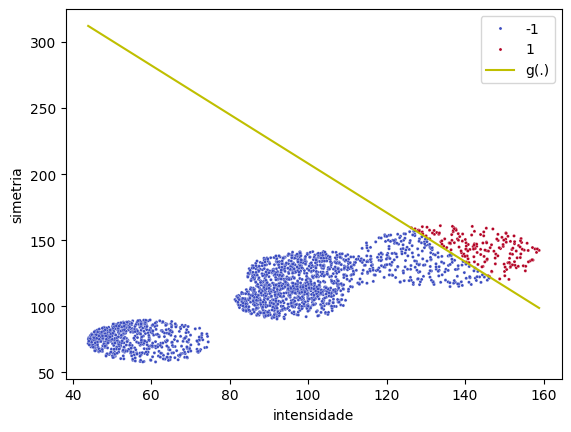

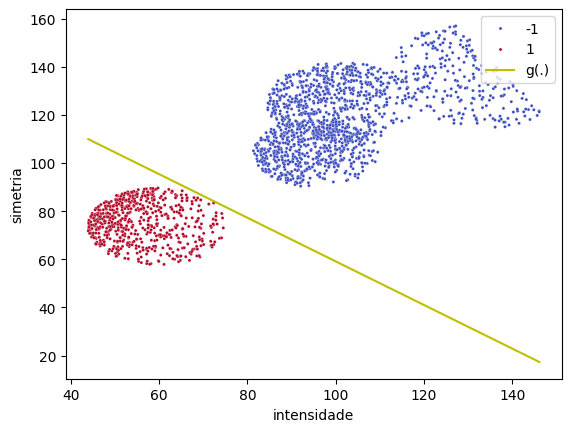

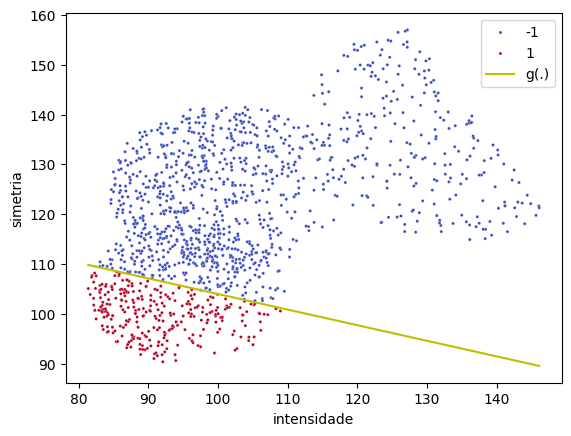

In [167]:
modelos = um_tds(train_redu)


In [168]:
def classe_0(x):
    pred = modelos[0].predict(x)
    return np.array(pred)

def classe_1(x):
    pred = modelos[1].predict(x)
    return np.array(pred)

def classe_4(x):
    pred = modelos[4].predict(x)
    return np.array(pred)

def classificador(x):
    if classe_0(x) == 1:
        return 0
    elif classe_1(x) == 1:
        return 1
    elif classe_4(x) == 1:
        return 4
    else:
        return 5  

In [169]:
pred_treino = [classificador(x) for x in X_train0_norm]

In [170]:
pd.Series(pred_treino).value_counts()

5    1116
1     608
4     289
0     173
Name: count, dtype: int64

In [171]:
pred_teste = [classificador(x) for x in X_test0_norm]

In [172]:
pd.Series(pred_teste).value_counts()

5    550
1    292
4    168
0    105
Name: count, dtype: int64

### Vizualização Gráfica

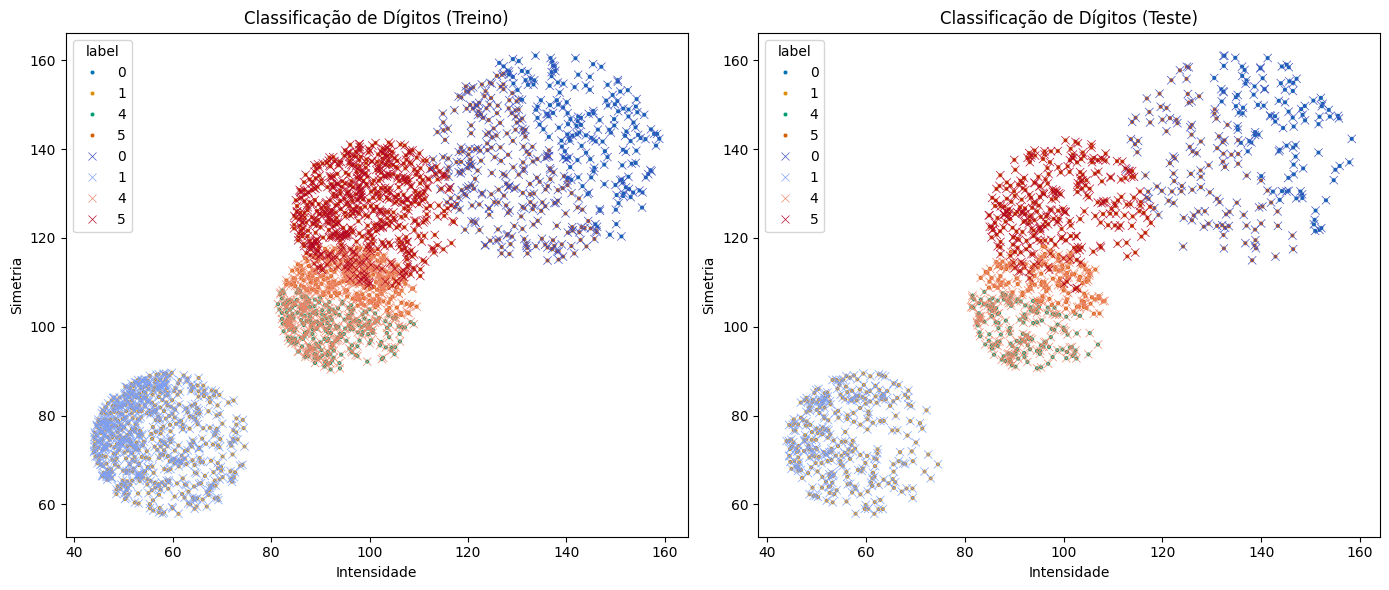

In [173]:
# Configurando o layout com 1 linha e 2 colunas
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot para treino
sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=pred_treino, data=train_redu, palette='colorblind', s=10, marker='o')
sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=train_redu['label'], data=train_redu, palette='coolwarm', marker='x')
axes[0].set_title('Classificação de Dígitos (Treino)')
axes[0].set_xlabel('Intensidade')
axes[0].set_ylabel('Simetria')

# Plot para teste
sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=pred_teste, data=test_redu, palette='colorblind', s=10, marker='o')
sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=test_redu['label'], data=test_redu, palette='coolwarm', marker='x')
axes[1].set_title('Classificação de Dígitos (Teste)')
axes[1].set_xlabel('Intensidade')
axes[1].set_ylabel('Simetria')

plt.tight_layout()
plt.show()

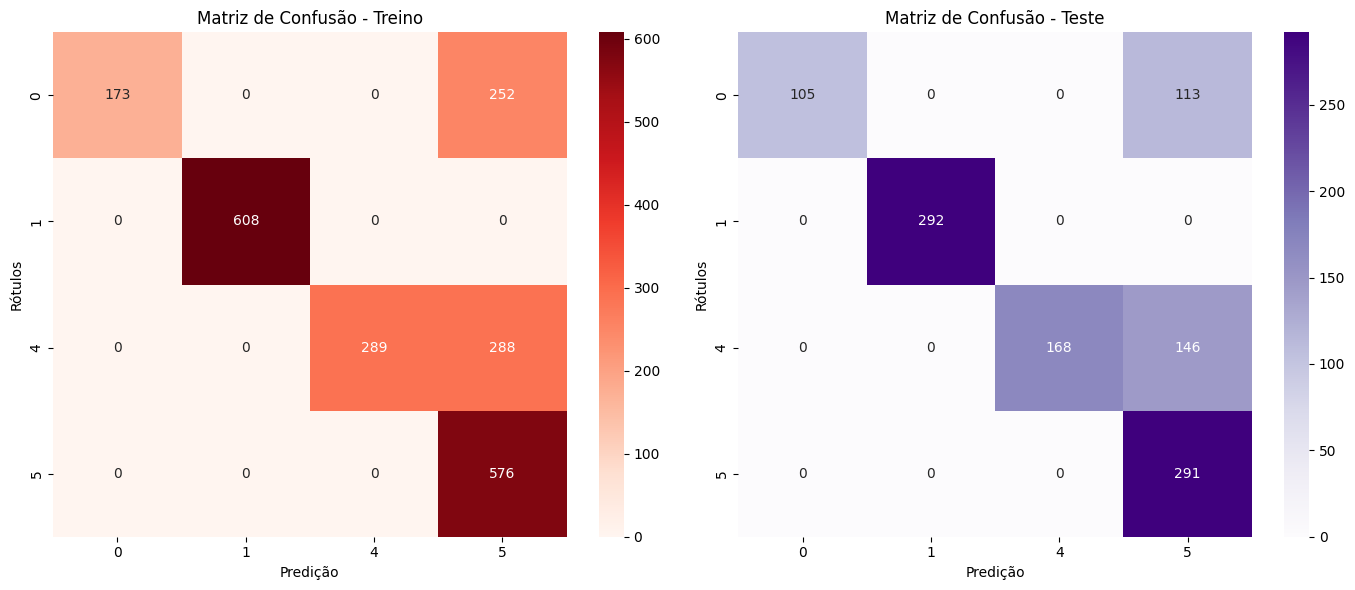

In [174]:
#convertendo em vetores 1D
y_train_f = y_train.flatten()
y_test_f = y_test.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))



cm_train = confusion_matrix(y_train_f, pred_treino)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[0])
axes[0].set_xlabel('Predição')
axes[0].set_ylabel('Rótulos')
axes[0].set_title('Matriz de Confusão - Treino')



cm_test = confusion_matrix(y_test_f, pred_teste)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[1])
axes[1].set_xlabel('Predição')
axes[1].set_ylabel('Rótulos')
axes[1].set_title('Matriz de Confusão - Teste')

plt.tight_layout()
plt.show()


## Eficiência da Classificação

In [175]:
pred_treino = np.array(pred_treino)
pred_teste = np.array(pred_teste)

train_accuracy = accuracy_score(y_train.T, pred_treino)
print(f'Acurácia no treino: {train_accuracy*100:.2f}%')

test_accuracy = accuracy_score(y_test.T, pred_teste)
print(f'Acurácia no teste: {test_accuracy*100:.2f}%')

Acurácia no treino: 75.30%
Acurácia no teste: 76.77%


In [176]:
N_in = len(train_redu)
eIn = 0
for i in range(N_in):
    if(pred_treino[i] != train_redu['label'][i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))


N_out = len(test_redu)
eOut = 0
for i in range(N_out):
    if(pred_teste[i] != test_redu['label'][i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.24702653247941445
Eout = 0.23228699551569507


In [177]:
print('Treino:')
print(classification_report(train_redu['label'].tolist(), pred_treino))

print('')

print('Teste:')
print(classification_report(test_redu['label'].tolist(), pred_teste))

Treino:
              precision    recall  f1-score   support

           0       1.00      0.41      0.58       425
           1       1.00      1.00      1.00       608
           4       1.00      0.50      0.67       577
           5       0.52      1.00      0.68       576

    accuracy                           0.75      2186
   macro avg       0.88      0.73      0.73      2186
weighted avg       0.87      0.75      0.75      2186


Teste:
              precision    recall  f1-score   support

           0       1.00      0.48      0.65       218
           1       1.00      1.00      1.00       292
           4       1.00      0.54      0.70       314
           5       0.53      1.00      0.69       291

    accuracy                           0.77      1115
   macro avg       0.88      0.75      0.76      1115
weighted avg       0.88      0.77      0.77      1115



In [178]:
print('Metricas de Erro - Treino')
print("Erro médio quadrático: ", mean_squared_error(y_train.T, pred_treino))
print("Erro médio absoluto: ", mean_absolute_error(y_train.T, pred_treino))

print('')

print('Metricas de Erro - Teste')
print("Erro médio quadrático: ", mean_squared_error(y_test.T, pred_teste))
print("Erro médio absoluto: ", mean_absolute_error(y_test.T, pred_teste))

Metricas de Erro - Treino
Erro médio quadrático:  3.0137236962488565
Erro médio absoluto:  0.7081427264409881

Metricas de Erro - Teste
Erro médio quadrático:  2.66457399103139
Erro médio absoluto:  0.6376681614349776
